# Model 4



In [129]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from geopy.distance import geodesic
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [130]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Trav_3_data_Final.xlsx')

df_copy = df.copy()

df_2 = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/model4_full.xlsx')

df_full = df_2.copy()

In [131]:
# define an element dictionary
from scipy.spatial import cKDTree

elements = {'Na_mM_EC', 'Ca_mM_EC', 'Mg_mM_EC', 'Si_mM_EC', 'K_mM_EC', 'Al_mM_EC'}

# make copies of elements Na_uM_EC etc

# Convert to μM and save as new columns
for elem in elements:
    new_col = elem.replace('_mM_', '_uM_')  # Replace 'mM' with 'uM' in the column name
    df_copy[new_col] = df_copy[elem] * 1000  # Convert mM to μM
    df_full[new_col] = df_full[elem] * 1000  # Convert mM to μM


elements_micro = {'Na_uM_EC', 'Ca_uM_EC', 'Mg_uM_EC', 'Si_uM_EC', 'K_uM_EC', 'Al_uM_EC'}

df_traverse3 = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_0 = {element: df_traverse3[element].min() for element in elements_micro}

for element in elements_micro:
    df_traverse3[f'C_0_{element}'] = C_0[element]


In [132]:
# Calculate C_eq as the maximum concentration for each element in df_traverse3
C_eq = {element: df_full[element].max() for element in elements_micro}

for element in elements_micro:
    df_traverse3[f'C_eq_{element}'] = C_eq[element]

# print the first 5 rows of C_eq_element
print(df_traverse3[[f'C_eq_{element}' for element in elements_micro]].head())


   C_eq_Mg_uM_EC  C_eq_Si_uM_EC  C_eq_K_uM_EC  C_eq_Ca_uM_EC  C_eq_Na_uM_EC  \
0     163.835453     869.214435     90.943239     960.514077      501.88711   
1     163.835453     869.214435     90.943239     960.514077      501.88711   
2     163.835453     869.214435     90.943239     960.514077      501.88711   
3     163.835453     869.214435     90.943239     960.514077      501.88711   
4     163.835453     869.214435     90.943239     960.514077      501.88711   

   C_eq_Al_uM_EC  
0      16.204954  
1      16.204954  
2      16.204954  
3      16.204954  
4      16.204954  


# Maher


In [133]:
A_a = 0.1  # Specific surface area (m^2/g)

X_r = 0.36  # Mineral concentration in rock (unitless, g/g)

rho_sf = 2.23 * 1000 / 0.3  # Mass mineral / fluid volume ratio (g/cm^3), assuming porosity = 0.3 [for now]

k = 10**(-15) # Reaction rate (mol/m^2/s)

R_n = rho_sf * A_a * k * X_r # Rate constant (mol/m^2/s)


In [134]:
def calculate_T_res_Model4_Maher(C, C_0, C_eq, R_n):

    # how to write e**2 in python?
    e2 = np.exp(2)

    T_res = (C_eq * (C - C_0)) / (e2 * R_n * (C_eq - C))
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-6) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float

# Apply calculation to each element in df_traverse3
for element in elements_micro:
    col_name = f'T_res_Maher_{element}'
    df_traverse3[f'T_res_Maher_{element}'] = df_traverse3.apply(
        lambda row: calculate_T_res_Model4_Maher(
            row[element], row[f'C_0_{element}'], row[f'C_eq_{element}'],
            R_n
        ), axis=1
    )



In [135]:
print("T_res Range for Each Element:")
for element in elements_micro:
    col_name = f'T_res_Maher_{element}'
    
    # Drop NaNs and ensure the column is numeric
    T_res_Maher_series = pd.to_numeric(df_traverse3[col_name], errors='coerce').dropna()

    if not T_res_Maher_series.empty:
        T_res_min = T_res_Maher_series.min()
        T_res_max = T_res_Maher_series.max()
        print(f"Element: {element}, T_res range: {T_res_min:.2f} to {T_res_max:.2f} years")
    else:
        print(f"Element: {element}, No valid T_res values available")


T_res Range for Each Element:
Element: Mg_uM_EC, T_res range: 0.00 to 0.37 years
Element: Si_uM_EC, T_res range: 0.00 to 11.28 years
Element: K_uM_EC, T_res range: 0.00 to 0.47 years
Element: Ca_uM_EC, T_res range: 0.00 to 2.23 years
Element: Na_uM_EC, T_res range: 0.00 to 7.65 years
Element: Al_uM_EC, T_res range: 0.00 to 0.02 years


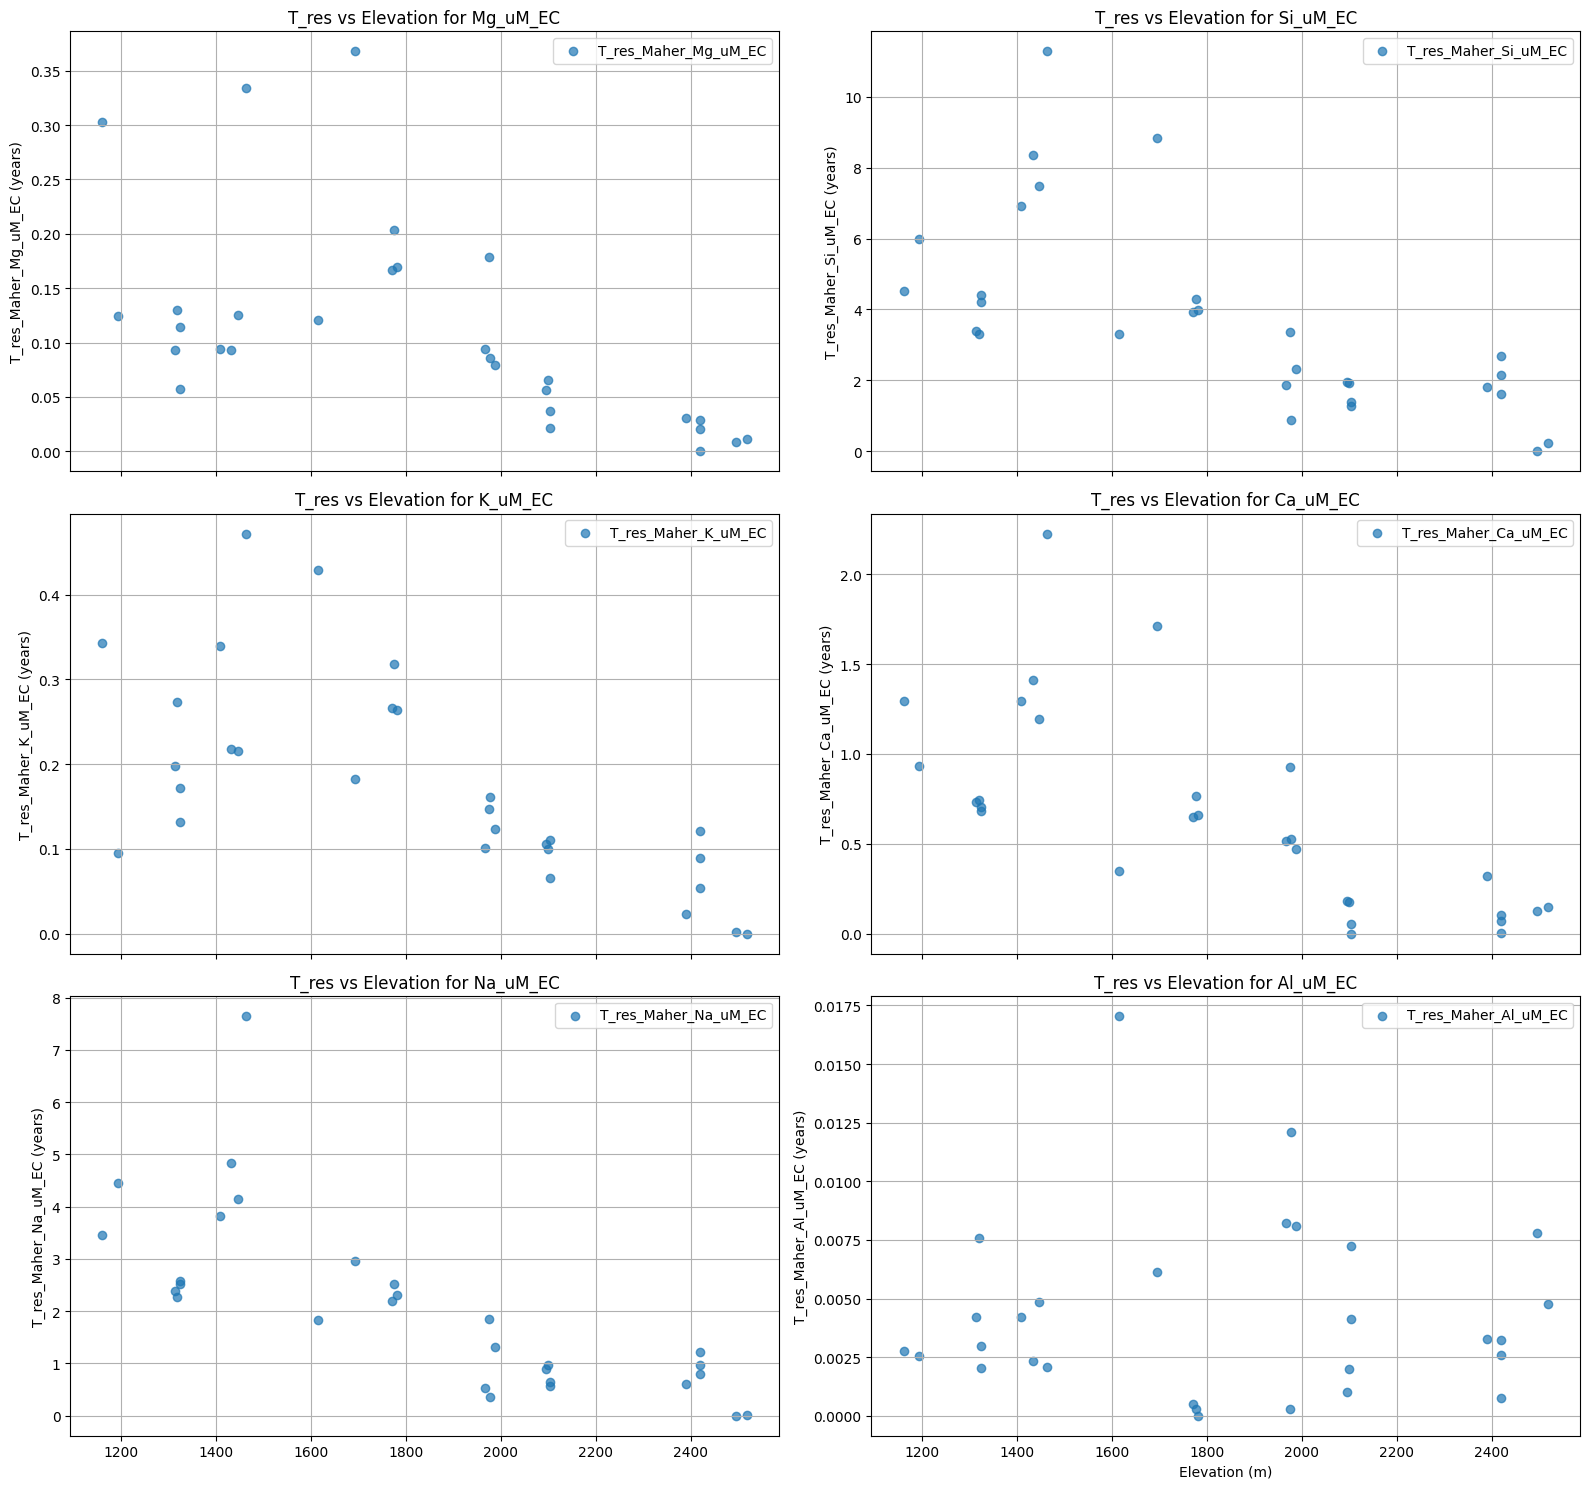

In [136]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse3[f"T_res_Maher_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Maher_{element}"], errors='coerce')

# Determine the number of elements
num_elements = len(elements_micro)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()



# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    ax.scatter(df_traverse3["Elevation"], df_traverse3[f"T_res_Maher_{element}"], alpha=0.7, label=f"T_res_Maher_{element}")
    ax.set_ylabel(f"T_res_Maher_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
plt.show()


# Fontorbe


In [137]:
S = 0.1  # Specific surface area (m^2/g)

X_r = 0.36  # Mineral concentration in rock (unitless, g/g)

rho_plag = 2.23 * 1000  # 2230 kg/m^3

k = 10**(-15) # Reaction rate (mol/m^2/s)

phi = 0.1

R_n_Fontorbe = k * S * rho_plag * 10**3 * X_r * (1-phi) # Rate constant (mol/m^2/s)

f = 0.1


In [138]:
def calculate_T_res_Model4_Fontorbe(C, C_0, R_n):


    T_res = (C - C_0) * phi / ((1-f) * R_n_Fontorbe )
    
    if isinstance(T_res, (list, tuple, np.ndarray)):
        T_res = T_res[0]  # Extract the first value if it's an array

    if not np.isscalar(T_res) or np.isnan(T_res):
        return np.nan  # Ensure we return a single number

    T_res_yr = T_res * 10**(-6) / 31557600 # Convert seconds to years
    
    
    return float(T_res_yr)  # Ensure it's a float

# Apply calculation to each element in df_traverse3
for element in elements_micro:
    col_name = f'T_res_Fontorbe_{element}'
    df_traverse3[f'T_res_Fontorbe_{element}'] = df_traverse3.apply(
        lambda row: calculate_T_res_Model4_Fontorbe(
            row[element], row[f'C_0_{element}'],
            R_n_Fontorbe
        ), axis=1
    )



In [139]:
print("T_res Range for Each Element:")
for element in elements_micro:
    col_name = f'T_res_Fontorbe_{element}'

    # Drop NaNs and ensure the column is numeric
    T_res_Fontorbe_series = pd.to_numeric(df_traverse3[col_name], errors='coerce').dropna()

    if not T_res_Fontorbe_series.empty:
        T_res_min = T_res_Fontorbe_series.min()
        T_res_max = T_res_Fontorbe_series.max()
        print(f"Element: {element}, T_res range: {T_res_min} to {T_res_max} years")
    else:
        print(f"Element: {element}, No valid T_res values available")


T_res Range for Each Element:
Element: Mg_uM_EC, T_res range: 0.0 to 0.0017301243463312738 years
Element: Si_uM_EC, T_res range: 0.0 to 0.03065681341589361 years
Element: K_uM_EC, T_res range: 0.0 to 0.0019123904758488006 years
Element: Ca_uM_EC, T_res range: 0.0 to 0.010709127988340878 years
Element: Na_uM_EC, T_res range: 0.0 to 0.02090123257369822 years
Element: Al_uM_EC, T_res range: 0.0 to 8.964492952169053e-05 years


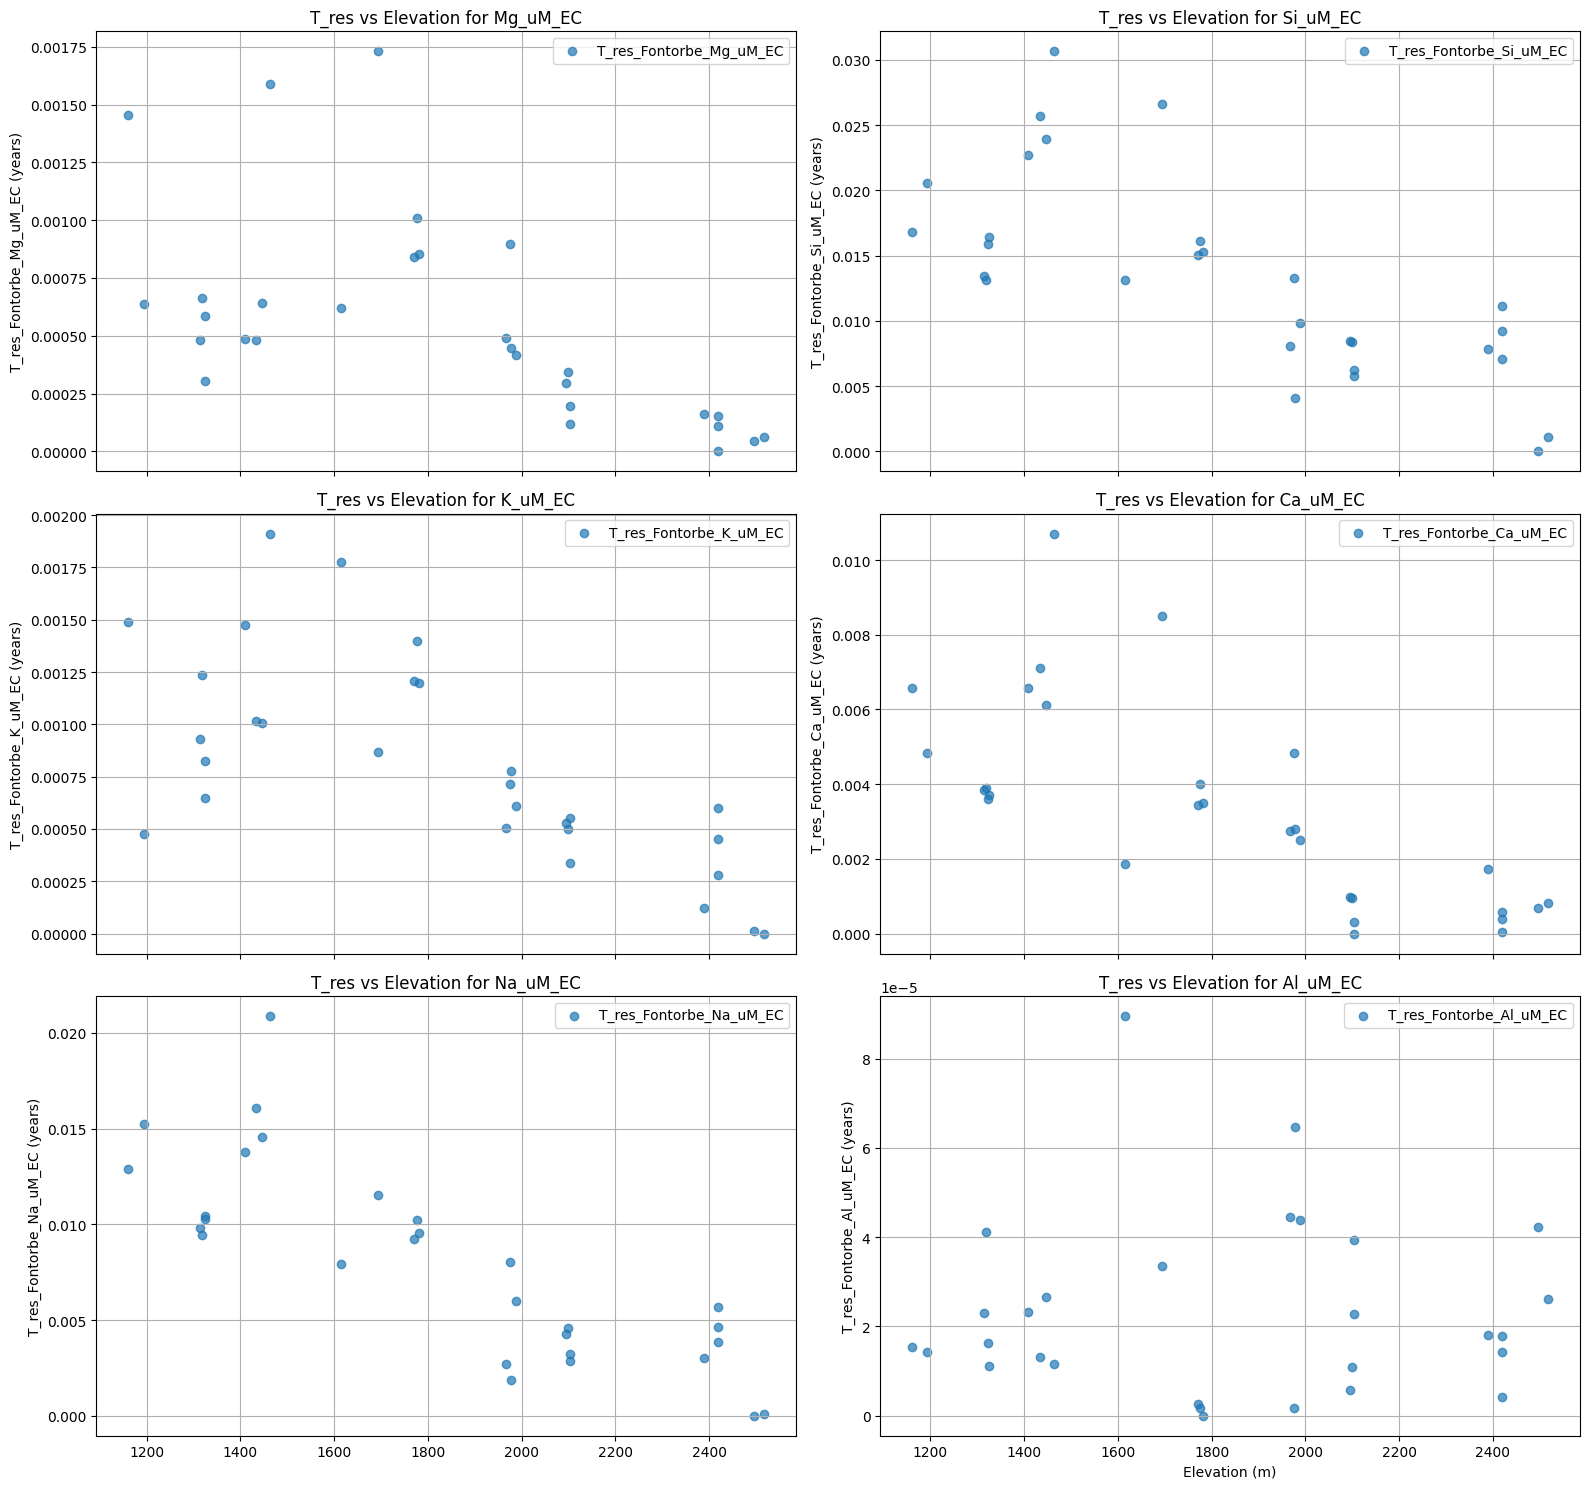

In [140]:
# Convert all T_res columns to numeric to avoid errors
for element in elements_micro:
    df_traverse3[f"T_res_Fontorbe_{element}"] = pd.to_numeric(df_traverse3[f"T_res_Fontorbe_{element}"], errors='coerce')

# Determine the number of elements
num_elements = len(elements_micro)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15), sharex=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each element and plot in a separate subplot
for ax, element in zip(axes, elements_micro):
    ax.scatter(df_traverse3["Elevation"], df_traverse3[f"T_res_Fontorbe_{element}"], alpha=0.7, label=f"T_res_Fontorbe_{element}")
    ax.set_ylabel(f"T_res_Fontorbe_{element} (years)")
    ax.set_title(f"T_res vs Elevation for {element}")
    ax.legend()
    ax.grid(True)

# Remove any unused subplots
for i in range(num_elements, len(axes)):
    fig.delaxes(axes[i])

# Set common x-axis label
axes[-1].set_xlabel("Elevation (m)")

# Adjust layout
plt.tight_layout()
plt.show()


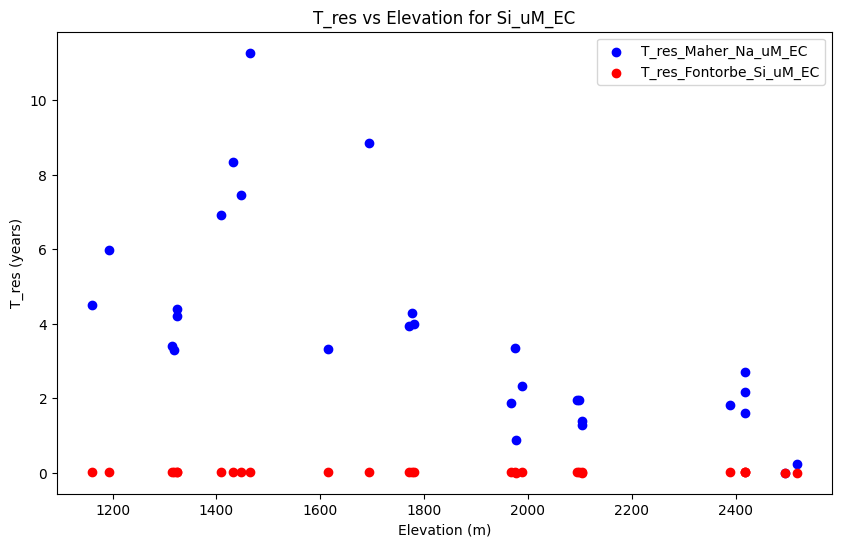

In [141]:
plt.figure(figsize=(10, 6))

# Plot the data
plt.scatter(df_traverse3['Elevation'], df_traverse3['T_res_Maher_Si_uM_EC'], label='T_res_Maher_Na_uM_EC', color = 'blue')
plt.scatter(df_traverse3['Elevation'], df_traverse3['T_res_Fontorbe_Si_uM_EC'], label='T_res_Fontorbe_Si_uM_EC', color = 'red')

# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('T_res (years)')

plt.title('T_res vs Elevation for Si_uM_EC')

# Add a legend
plt.legend()
plt.yscale('log')
# Display the plot
plt.show()

